# Assignment 3

In [991]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import coo_matrix, linalg
from timeit import timeit
import matplotlib.pyplot as plt
import numba

## Part 1: Implementing a CSR Matrix

Below a new class is defined that allows transformation of sparse matrices into CSR format. As the class is initialised the row, col and data parts of the COO matrix are placed in order of increasing size initally with respect to columns and then this is overwritten with respect to rows. This allows for a better approach to COO to CSR conversion.

In [1171]:
class CSRMatrix(LinearOperator):
    def __init__(self, coo_matrix):
        self.shape = coo_matrix.shape
        
        
        #creating a csr array and sorting
        arr = np.empty((3,coo_matrix.row.shape[0]))
        arr[0,:] = coo_matrix.row
        arr[1,:] = coo_matrix.col
        arr[2,:] = coo_matrix.data
        i = np.argsort(arr[1,:])
        arr = arr[:,i] #sort by columns in increasing size
        j = np.argsort(arr[0,:])
        arr = arr[:,j] #sort by rows
        
        #assigning sorted values to variables
        self.row = arr[0,:].astype('int64')
        self.indices = arr[1,:].astype('int64')
        self.data = arr[2,:]
        
        
        
        self.indptr = []
        
        #converting from COO to CSR format
        x = -1
        for i, val in enumerate(self.row):
            if (val != x):
                self.indptr.append(i)
                for q in np.arange(val-x-1):
                    self.indptr.append(i)
                x = val
        if x < (self.shape[0]):
            for q in np.arange(self.shape[0]-x):
                    self.indptr.append(self.indices.shape[0])
        self.indptr = np.array(self.indptr)


    def __add__(self, other):
        """Adds the CSR matrix other to this matrix, adds them togther in the COO format and then returns a
        reinitalised CSR matrix."""
        
        #concatenating data into one array
        z_row = np.hstack((self.row, other.row))
        z_col = np.hstack((self.indices, other.indices))
        z_data = np.hstack((self.data, other.data))
        z = np.vstack((z_row, z_col, z_data))

        z_cut = np.empty((3,0))
        
        #adding the coo matrix together
        for i in range(z.shape[1]):
            match = False
            for j in range(z_cut.shape[1]):
                if (z[:2,i] == z_cut[:2,j]).all():
                    z_cut[2,j] += z[2,i]
                    match = True
                    break
            if match == False:        
                z_cut = np.append(z_cut,z[:,i].reshape(3,1),axis=1)

        #rouning the matrices into integers
        z_row = np.round(z_cut[0,:], decimals=0).astype(np.int32)
        z_col = np.round(z_cut[1,:],decimals=0).astype(np.int32)
        
        return CSRMatrix(coo_matrix((z_cut[2,:],(z_row,z_col)), shape=self.shape))
    
    def _matvec(self, vector):
        """Compute a matrix-vector product."""
        
        y = np.zeros(self.shape[0], dtype=np.float64)
        
        #multiplying the matrices together in CSR format
        for row_index in range(self.shape[0]):
            col_start = self.indptr[row_index]
            col_end = self.indptr[row_index + 1]
            for col_index in range(col_start, col_end):
                y[row_index] += self.data[col_index] * vector[self.indices[col_index]]
        
        return y

### Validity Check

Checking validity of class functions created above for matrices of various sizes, including non square matrices.

In [1172]:
nums = np.logspace(1,2,3,dtype=int)
density = 0.1

#checking validity of class for different array sizes
for n1 in nums:
    for n2 in nums:
    
        #creating sample
        mat1_coo = sp.random(n1,n2,density=density)
        mat1_dense = mat1_coo.todense()
        mat2_coo = sp.random(n1,n2,density=density)
        mat2_dense = mat2_coo.todense()

        mat1 = CSRMatrix(mat1_coo)
        mat2 = CSRMatrix(mat2_coo)
        mat3 = mat1.__add__(mat2)


        b = np.random.randn(n2)
        dense_add_csr = sp.csr_matrix(mat1_dense+mat2_dense)

        #testing class
        assert (np.sort(dense_add_csr.data,axis=0) == np.sort(mat3.data)).all() #adding - checking data
        assert (np.sort(dense_add_csr.indices,axis=0) == np.sort(mat3.indices)).all() #adding - checking indices
        assert (np.sort(dense_add_csr.indptr,axis=0) == np.sort(mat3.indptr)).all() #adding  - checking indptr
        assert np.allclose(mat1_dense@b, mat1._matvec(b),atol=1e-10,rtol=1e-10) #matvec check

### Timing Functions

Measuring the time taken for the matvec function for each of various array sizes against the numpy matrix vector product for various sparsities.

In [1062]:
nums = np.logspace(0,4,10,dtype=int)

num_repeats = 10
densities = np.logspace(-3,-1,3)

times_matvec = np.zeros((densities.shape[0],len(nums)))
times_numpy = np.zeros((densities.shape[0],len(nums)))

#storing times taken to for matvec for different matrix sizes
for j, density in enumerate(densities):
    for i, num in enumerate(nums):
        mat1_coo = sp.random(num,num,density=density)
        mat1_dense = mat1_coo.todense()
        mat1 = CSRMatrix(mat1_coo)
        b = np.random.rand(num)

        times_matvec[j,i] = timeit(lambda: mat1._matvec(b),number = num_repeats)
        times_numpy[j,i] = timeit(lambda: mat1_dense@b,number = num_repeats)

### Plotting Time Comparisons

Below two time measurements are plotted over a series of different matrix sizes. One measures the time taken to calculate matrix vector products using the defined matvec function and the matrix in CSR format and the other uses the numpy '@' function in a dense format.

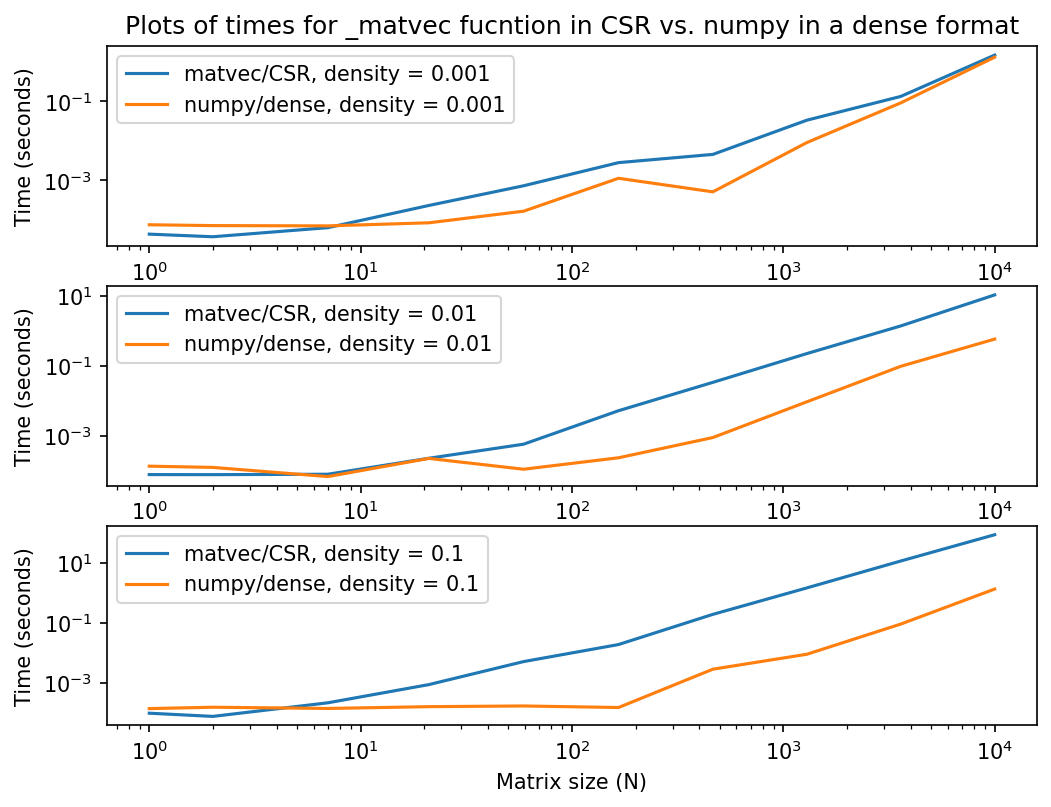

In [1064]:
fig, ax = plt.subplots(3,1,dpi=150,figsize=(8,6))
ax[0].set_title('Plots of times for _matvec fucntion in CSR vs. numpy in a dense format')
for i, density in enumerate(densities):
    ax[i].plot(nums, times_matvec[i,:], label=f'matvec/CSR, density = {density}')
    ax[i].plot(nums, times_numpy[i,:], label=f'numpy/dense, density = {density}')
    ax[i].legend()
    ax[i].set_xlabel('Matrix size (N)')
    ax[i].set_ylabel(f'Time (seconds)')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')

From the graphs above it is possible to see that the numpy method of dense matrix-vector multiplication takes slightly longer than the CSR matvec method for matrices smaller than size 10. For matrices larger than this the matvec method begins to take a larger amount of time than numpy. This is likely because the numpy method must has been highly optimised over many years, whereas the matvec method implemented has two for-loops which cycle through elementwise rather than in parallel. As the density of the matrices are decreased however, the advantages of the CSR format show, this can be seen by the decreasing time difference between numpy and matvec as the matrix density decreases. For a density of 0.001 at a size of $n = 10^4$, the numpy and matvec method have equal calculation times.

### Comparing the Results from GMRES and CG Iterative Methods

In [959]:
N = 21

#this makes the matrix A positive definite symmetric
Q, _ = np.linalg.qr(np.random.randn(N, N))
D = np.diag(np.random.rand(N))
A = Q.T @ D @ Q

b = np.random.rand(N)

residual_gm = []
f_gm = lambda res: residual_gm.append(res)
residual_cg = []
f_cg = lambda x: residual_cg.append(np.linalg.norm(b - A @ x) / np.linalg.norm(b))

sol_gm, info_gm = sp.linalg.gmres(A, b,callback=f_gm,tol=1e-10,maxiter=1000)
sol_cg, info_cg = linalg.cg(A, b, tol=1e-10, callback=f_cg, maxiter=1000)

All close: True
Exactly the same: False
Error: 0.0.


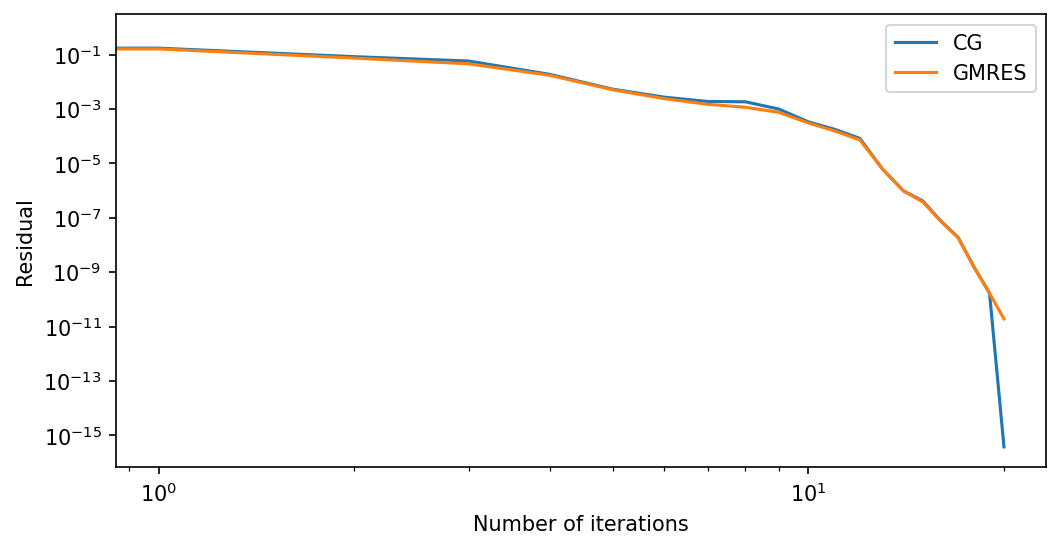

In [1007]:
#plotting residuals
plt.figure(dpi=150, figsize=(8,4))
plt.plot(np.arange(0,len(residual_cg)),residual_cg, label='CG')
plt.plot(np.arange(0,len(residual_gm)),residual_gm, label='GMRES')
plt.xlabel('Number of iterations')
plt.ylabel('Residual')
plt.xscale('log')
plt.yscale('log')
plt.legend()

#comparison of the solutions
print('All close:',np.allclose(sol_gm,sol_cg))
print('Exactly the same:',(sol_gm == sol_cg).all())

rel_diff = np.linalg.norm(sol_gm - sol_cg, np.inf) / np.linalg.norm(sol_gm, np.inf)
print(f"Error: {np.round(rel_diff, decimals = 5)}.")

The solutions to the matrix vector probelm provided by the GMRES and CG tools are very similar, however they are not exactly the same. This is because these tools apply different iterative numerical methods as opposed to analytical methods to solve the matrix vector problem. Iterative methods allow for an increases in calculation efficiency and can provide very similar answers, this is shown by the 'True' output from the allclose() function above the graph. Although the two functions do not create exactly equivalent solutions, they are still useful as the accuracy of the solutions can be defined such that the residuals are smaller than a tolerance of up to $10^{-16}$.

## Part 2: Implementing a custom matrix

### Creating a Class Implementation of the custom matrix format

The matvec function is optimised for matrices of this custom shape. It performs a simple element-wise multiplication between the diagonal and the top half of the vector. It also performs a normal matrix-vector multiplication between the bottom right quarter and the bottom half of the vector. This is split into the multiplication $T(Wv)$, where $W$ and $v$ are multiplied first as they create a smaller product matrix that requires a smaller amount of storage, then $T$ is applied to this products to create the final answer.

In [1162]:
class CUSTMatrix(LinearOperator):
    def __init__(self, T, W, diag):
        
        #storing useful values
        self.N = T.shape[0]
        self.shape = (2*T.shape[0], 2*T.shape[0])
        self.W = W
        self._T = T
        self.diag = diag
        
    def _matvec(self, vector):
        """Applies a matrix vector operation in an efficient manner and returns the solution array."""
        #multiplies diagonal part
        diag_part = np.multiply(self.diag,vector[:self.N])
        
        #multiplying the Atil part
        Atil_semi = self.W @ vector[self.N:]
        Atil = self._T @ Atil_semi
        
        #placing elements in array
        arr = np.zeros(self.shape)
        arr[:self.N,:self.N] = np.diag(diag_part)
        arr[self.N:,self.N:] = Atil
        
        return arr
    
    def CSR(self):
        """Returns the matrix in CSR format."""
        #creating dense matrix
        arr = np.zeros(self.shape)
        arr[:self.N,:self.N] = np.diag(self.diag)
        arr[self.N:,self.N:] = self._T @ self.W
        
        return sp.csr_matrix(arr)
    
    def dense(self):
        """Returns the matrix in a dense format."""
        #creating dense matrix
        arr = np.zeros(self.shape)
        arr[:self.N,:self.N] = np.diag(self.diag)
        arr[self.N:,self.N:] = self._T @ self.W
        
        return arr

### Timing the _matvec implementation for the Custom matrix structure

Below the matvec function is timed over a range of sizes and for several equivalent randomly initialised matrices, the timings of which are then averaged and outputted to give more reliable results.

In [1124]:
def cust_mat(N):
    """Creates componenets of a custom matrix of size N, fills each with random numbers."""
    
    T = np.random.rand(N,2)
    W = np.random.rand(2,N)
    diag = np.random.rand(N)
    
    return T, W, diag

In [1168]:
sizes = np.logspace(1,4,7,dtype='int64')
averages = 10
elements = dict()
matrices = dict()
vectors = dict()
times_cust = np.empty((averages, sizes.shape[0]))
times_csr = np.empty((averages, sizes.shape[0]))
times_dense = np.empty((averages, sizes.shape[0]))
num_repeats = 1


#storing range of variables and matrices
for avg in range(averages):
    for i, size in enumerate(sizes):
        elements[0, i], elements[1,i], elements[2,i] = cust_mat(size)
        matrices[i] = CUSTMatrix(elements[0, i], elements[1,i], elements[2,i])
        vectors[i] = np.random.rand((elements[0,i].shape[0]*2))

        times_cust[avg,i] = timeit(lambda: matrices[i]._matvec(vectors[i]),number = num_repeats)
        times_csr[avg,i] = timeit(lambda: matrices[i].CSR() @ vectors[i],number = num_repeats)
        times_dense[avg,i] = timeit(lambda: matrices[i].dense() @ vectors[i],number = num_repeats)
        
times_cust = np.average(times_cust, axis = 0)
times_csr = np.average(times_csr, axis = 0)
times_dense = np.average(times_dense, axis = 0)

### Plotting the times

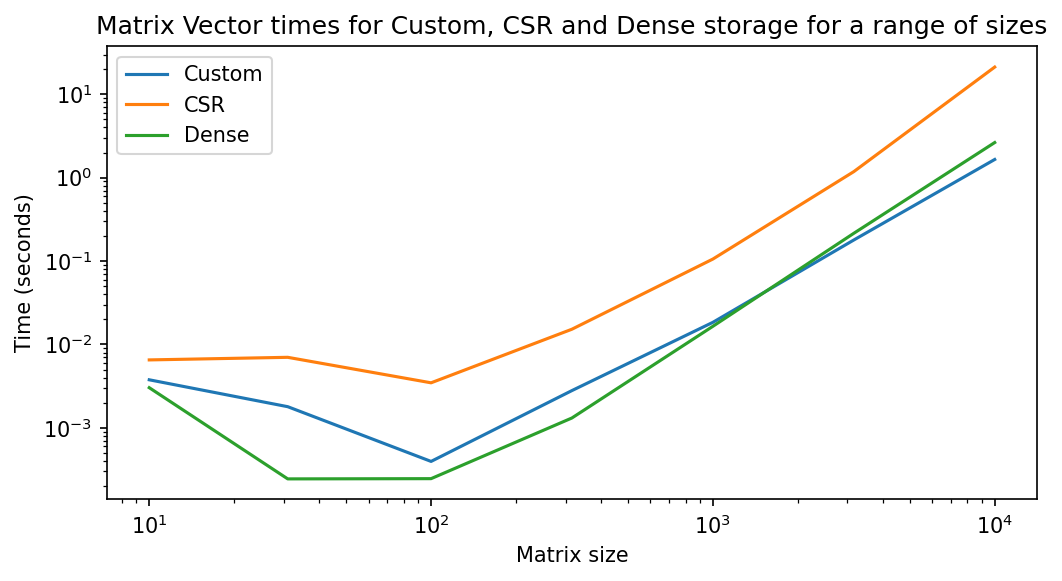

In [1170]:
#plotting times
plt.figure(dpi=150, figsize=(8,4))
plt.title('Matrix Vector times for Custom, CSR and Dense storage for a range of sizes')
plt.plot(sizes, times_cust, label='Custom')
plt.plot(sizes, times_csr, label='CSR')
plt.plot(sizes, times_dense, label='Dense')
plt.xlabel('Matrix size')
plt.ylabel('Time (seconds)')
plt.xscale('log')
plt.yscale('log')
plt.legend()

For small a range of matrix sizes between n = 10 and n = 1000 the dense numpy multiplication is faster than the custom method, this is likely due to the simplicity of one numpy multiplication in comparison to the several lines of code in the matvec function. However, for  matrix sizes larger than n = 1000 the custom matvec method becomes faster than the dense numpy multiplication. This is likely because the number of calculations required of the numpy method is around 4 times as many as is required from the custom method. Therefore at larger sizes, numpy's more simple and less code intensive approach is overshadowed by the sheer number of calculations in comparison to the custom method. At all times the CSR approach is also slower, this is potentially because one quarter of the matrix is dense and so the data size is not considerably reduced but the storage structure creates a more computationally expensive matvec function. At much larger matrix sizes one might expect this to be faster than the numpy method.